In [36]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from os import mkdir, remove, rmdir


In [37]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [38]:
print(cmip6vars)

{'sfcWindmax': 'SWM', 'sfcWind': 'SW', 'psl': 'SLP', 'tas': 'TAS', 'ua': 'UA', 'ta': 'TA', 'tos': 'TOS'}


In [39]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=2E6
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season+scen
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)


In [6]:
#cell to test ncdf imports and preprocess
modname = 'ACCESS-ESM1-5'
#fn = pathinvar+modname+'_'+basenamemet+".nc"
fn = make_fn([modname],basenamemet,filetype=".nc")
ncdf1 = xr.open_dataset(pathinvar+fn)
ncdf_past = ncdf1['historical']
ncdf_qt = ncdf_past.quantile(qt,dim=("day","member"))
haz = set_centroids(ncdf_past,timeres="day")
#haz.plot_rp_intensity(smooth=False)

/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':'WS max intensity at each point'}>

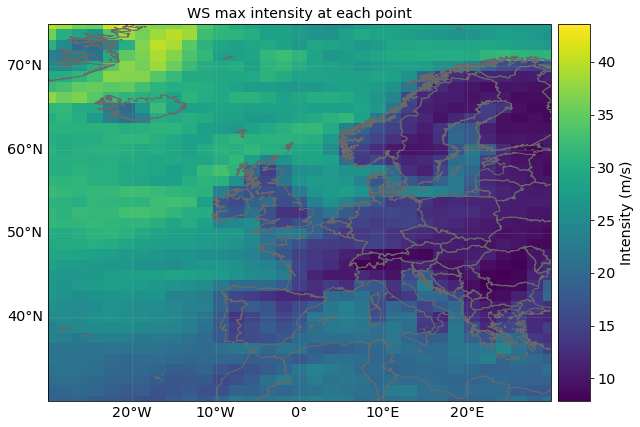

In [6]:
haz.plot_intensity(event=0,smooth=False)

# Exposure

In [40]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'LitPop Exposure for Europe, 2018\nProduced capital')

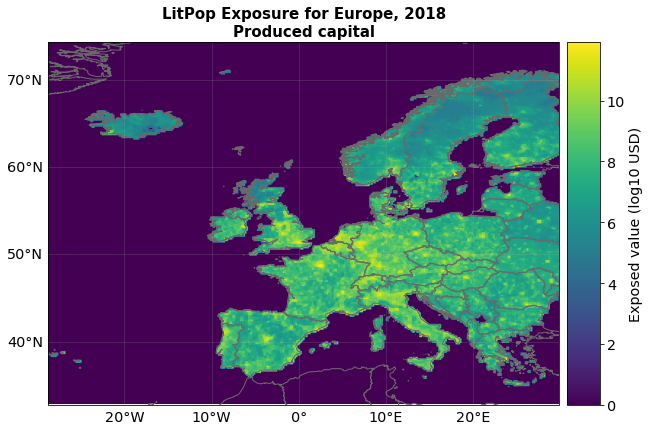

In [8]:
#ax = exp.plot_hexbin(pop_name=False,vmin=1E7,vmax=1E11
ax = exp.plot_raster(label='Exposed value (log10 USD)')

ax.set_title('LitPop Exposure for Europe, 2018\nProduced capital',fontsize=15,fontweight="bold")
#plt.savefig(savefigpath+'/Exposures/hexbin_exp_cropped600EU.png',transparent=False)

# Impact functions
1) Import sigmoid from Emanuel
2) Import empirical from Schwierz
3) Construct Cubic EOT (same intensity scale as Schwierz)

In [41]:
## impact function
from climada.entity.impact_funcs import storm_europe, ImpfTropCyclone

# Here we generate the impact function for TC damage using the formula of Emanuel 2011
impFunc_schw = storm_europe.ImpfStormEurope.from_schwierz()
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa()

# plot the impact function
impFunc_emanuel_usa.id = 0
impFunc_emanuel_usa.haz_type = 'WS'
impFunc_emanuel_usa.check()

impFunc_schw.id = 0
impFunc_schw.haz_type = 'WS'
impFunc_schw.check()

2022-06-16 14:42:11,262 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [42]:
# Implement impact function cubic excess from Prahl 2015 
from climada.entity import ImpactFunc
imp_fun_cub = ImpactFunc()
imp_fun_cub.haz_type = 'WS'
imp_fun_cub.id = 0
imp_fun_cub.name = 'Cubic excess-over-threshold'
# provide unit of the hazard intensity
imp_fun_cub.intensity_unit = 'm/s'
imp_fun_cub.intensity = impFunc_schw.intensity
#imp_fun_cub.intensity = np.linspace(0, 1, num=20)
#imp_fun_cub.mdd = imp_fun_cub.intensity**3
imp_fun_cub.mdd = (imp_fun_cub.intensity/np.max(imp_fun_cub.intensity))**3
imp_fun_cub.intensity = np.append(imp_fun_cub.intensity, [100])
imp_fun_cub.mdd = np.append(imp_fun_cub.mdd, [1])
imp_fun_cub.paa = np.ones(imp_fun_cub.intensity.shape)
# check if the all the attributes are set correctly
imp_fun_cub.check()


2022-06-16 14:42:15,438 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-06-16 14:42:18,269 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-06-16 14:42:18,270 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-06-16 14:42:18,294 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-06-16 14:42:18,294 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-06-16 14:42:18,310 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


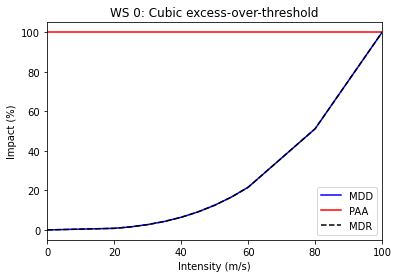

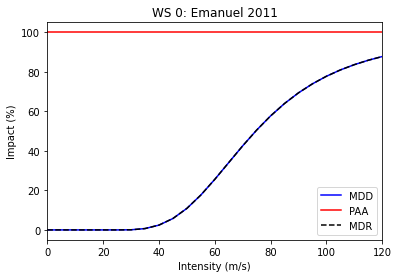

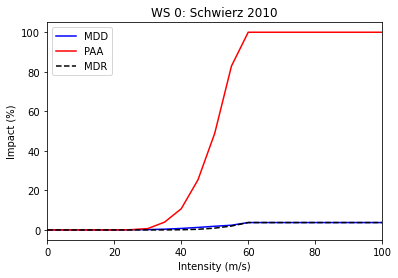

In [43]:
# generate 1 impf set per impact function 
from climada.entity import ImpactFuncSet
impf_list = [imp_fun_cub,impFunc_emanuel_usa,impFunc_schw]
impf_namelist = []
impf_dict = dict()
axs=[]
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set = ImpactFuncSet()
    impf_set.append(impf)
    impf_set.check()
    ax = impf_set.plot()
    axs.append(ax)
    #plt.ylim((0,105))
    #plt.xlim((0,1))

    impf_dict[impfname] = impf_set
#axs[0].set_xlabel('Normalized intensity (-)')
#axs[0].set_xlim((0,2))
#axs[1].set_xlabel('Normalized intensity (-)')
#axs[1].set_xlim((0,4))

2022-06-15 15:27:45,322 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-06-15 15:27:45,323 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-06-15 15:27:45,346 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-06-15 15:27:45,346 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-06-15 15:27:45,365 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


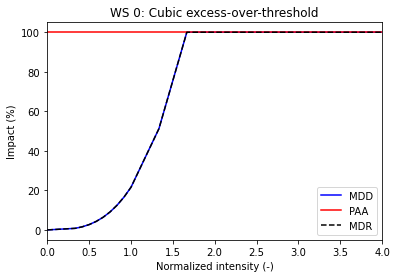

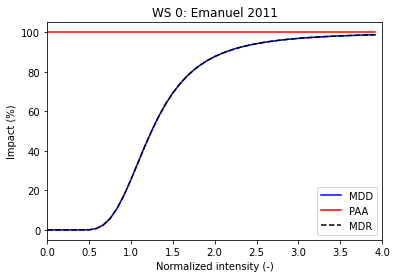

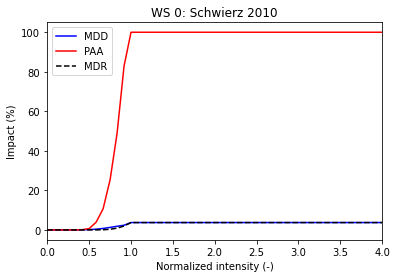

In [151]:
# generate 1 impf set per impact function, norm impf
from climada.entity import ImpactFuncSet
impf_list = [imp_fun_cub,impFunc_emanuel_usa,impFunc_schw]
impf_namelist = []
impf_dict_norm = dict()
axs=[]
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set = ImpactFuncSet()
    impf_norm = norm_impf(impf,scale=1)
    impf_set.append(impf_norm)
    impf_set.check()
    ax = impf_set.plot()
    ax.set_xlabel('Normalized intensity (-)')
    ax.set_xlim((0,4))
    axs.append(ax)
    #plt.ylim((0,105))
    #plt.xlim((0,1))

    impf_dict_norm[impfname] = impf_set


In [150]:
def norm_impf(impf,vmax=60,scale=1):
    '''Function that takes an impact function object and return its normalized intensity version'''
    norm_impf = cp.deepcopy(impf)
    if impf.name == 'Emanuel 2011':
        #allow for extension of the intensity
        new_intensity = np.arange(0,2*np.max(norm_impf.intensity),5)
        norm_impf = ImpfTropCyclone.from_emanuel_usa(intensity=new_intensity)
        norm_impf.intensity = scale*norm_impf.intensity/vmax
        norm_impf.paa = np.ones(norm_impf.intensity.shape)
        
    else:
        #cap values
        norm_impf.intensity = scale*norm_impf.intensity/vmax
        norm_impf.intensity = np.append(norm_impf.intensity, [10])
        norm_impf.mdd = np.append(norm_impf.mdd, [np.max(norm_impf.mdd)])
        norm_impf.paa = np.append(norm_impf.paa, [np.max(norm_impf.paa)])
    norm_impf.id=0
    norm_impf.haz_type='WS'
    
    return norm_impf
impf_norm = norm_impf(impf,scale=1)

In [31]:
np.arange(0,2*np.max(impf.intensity),5)
np.ones(impf.intensity.shape)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

# Main calculation cell
Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
1) Loop over impact functions
2) Loop over scenarios
3) Loop over climate models
4) Loop over model members


In [10]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Schwierz 2010']

In [11]:
scenlist

['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

In [12]:
modlist_allscen

['CanESM5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'FGOALS-g3',
 'ACCESS-ESM1-5',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'KACE-1-0-G']

In [27]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
modlist = modlist_allscen[:2]
impf_used = impf_namelist
scen_used= scenlist
pastname = 'historical'
timeres='day'
nmems = 3
caltype = 'nocal'

In [28]:
#initiate df to save results
metrics = ["AAI_agg","45 yr impact","90 yr impact"]
itercol = [scenlist,impf_namelist,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["scenario","impf","metric"])
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","member"])


In [29]:
##main calculation cell.
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
stack = False
norm = True #normalize intensity
savehaz = False
saveimpmat = False
saveimpcsv = False
savestats = True
#test = 'exp1000' # flat exposure
#test = 'stepexp' # step exposure
#test = 'flatwind_'
test = ''
if_id = 0
it = 0 #iteration count
df_list = []
impf_keys = []

#initiate df
if stack:
    res_df = pd.DataFrame(columns=col_idx,index=modlist)
    nmems=1
else:
    res_df = pd.DataFrame(columns=col_idx,index=row_idx)

for modid, modname in enumerate(modlist):
    
    #select preprocessing function
    if norm:
        preprocess_func = scale_qt
    else:
        preprocess_func = mask_qt
    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    
    #iterate over the scenarios
    for scen in scen_used:
        #select simulation
        ncdf_sel = ncdf[[pastname,scen]]
        #apply gust factor
        gust_ds = gst_fact*ncdf_sel
        
        #iterate over the members
        for nmem in range(nmems):
            print('iterating over member: '+str(nmem))
            
            #preprocess fields
            if stack:
                mem_da = gust_ds
            else: 
                mem_da = gust_ds.sel(member=nmem)
        
            gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
            gust_pp_sel = gust_pp[scen]
            
            #prepare hazards centroids
            haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)
            
            ##save hazard if required
            #get names 
            if norm:
                pp_funcname = 'scale_qt'
            else:
                pp_funcname = 'mask_qt'
            savenamehaz = make_fn([pp_funcname],basenamemet_proc)  
            if stack:
                simname = 'stacked'
                savesubdir = 'stacked/'+scen+'/'
            else:
                simname = 'nmem'+str(nmem)
                savesubdir = 'memsep/'+scen+'/'
                
            if savehaz:
                try:
                    haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                except FileNotFoundError:
                    mkdir(pathhaz+savesubdir)
                    haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
            print(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
            
            #prepare exposure
            # deepcopy exposure before assigning centroids
            exp_sel = cp.deepcopy(exp)
            
            #assign centroids
            exp_sel.assign_centroids(haz,distance='approx',threshold=300)
            exp_sel.check()
            
            ####### dummy exposure
            #exp_sel.gdf.value = 1000
            #test = 'stepexp' # step exposure
            
            #iterate over impact function
            for impf in impf_used:
                # get impfset
                if norm:
                    impf_set = impf_dict_norm[impf]
                else:
                    impf_set = impf_dict[impf]
            
                #calibrate impf
                if caltype!='nocal':
                    calname = make_fn(["cal",caltype],basenamemet_proc,filetype=".csv")
                    paramspath = pathcal+calname
                    param = pd.read_csv(paramspath,header=[0,1,2],index_col=0).loc[modname,(impf_namesht,"historical","AAI_agg")]
                    impf_set = tune_impf(impf_set,param,modname,plot=False)
                    if_id = 1 #select calibrated impf
                    
                #get names
                impf_namesht = impf_sht_names[impf]
                if norm:
                    impf_namesht = impf_namesht+'_norm'
                savenameimp = make_fn([impf_namesht,caltype],basenamemet_proc)
                # Exposures: rename column and assign id
                exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                exp_sel.gdf['impf_' + haz_type] = if_id
                
                #compute impacts
                #past
                start_time = timer()
                imp = Impact()
                imp.calc(exp_sel, impf_set, haz, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
                time_delta_past = timer() - start_time
                print(time_delta_past)
    
                #save results
                if savestats:
                    #compute freq curves 
                    imp45 = imp.calc_freq_curve(return_per=45).impact 
                    imp90 = imp.calc_freq_curve(return_per=90).impact 
                    if stack:
                        res_df.loc[modname,(scen,impf,"AAI_agg")] = imp.aai_agg
                        res_df.loc[modname,(scen,impf,"45 yr impact")] = imp45
                        res_df.loc[modname,(scen,impf,"90 yr impact")] = imp90
                    else: 
                        res_df.loc[(modname,nmem),(scen,impf,"AAI_agg")] = imp.aai_agg
                        res_df.loc[(modname,nmem),(scen,impf,"45 yr impact")] = imp45
                        res_df.loc[(modname,nmem),(scen,impf,"90 yr impact")] = imp90
                
                #save impacts
                if saveimpcsv:
                    try:
                        #rmdir(pathimp+'impact csv/memsep/'+scen+"/")
                        #mkdir(pathimp+'impact csv/memsep/'+scen+"/")
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact csv/aggregated/'+savesubdir)
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                if saveimpmat:
                    try:
                        #rmdir(pathimp+'impact matrices/'+savesubdir)
                        #mkdir(pathimp+'impact matrices/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact matrices/aggregated/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                del imp #del impact object
            del exp_sel
            del haz
                
        it = it+1       

res_df = res_df.astype(np.float64)

iterating over member: 0
/home/lseverino/MT/scripts/results/hazards/memsep/historical/haz_nmem0_historical_CanESM5_scale_qt_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_day_EU_winE_allscens.h5
0.09591411799192429
/home/lseverino/MT/scripts/results/impacts/impact matrices/aggregated/memsep/historical/imp_nmem0_historical_CanESM5_CubEOT_norm_nocal_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_day_EU_winE_allscens.npz
0.03198269009590149
/home/lseverino/MT/scripts/results/impacts/impact matrices/aggregated/memsep/historical/imp_nmem0_historical_CanESM5_Em2011_norm_nocal_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_day_EU_winE_allscens.npz
0.025034762918949127
/home/lseverino/MT/scripts/results/impacts/impact matrices/aggregated/memsep/historical/imp_nmem0_historical_CanESM5_Sw2010_norm_nocal_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_day_EU_winE_allscens.npz
iterating over member: 1
/home/lseverino/MT/scripts/results/hazards/memsep/historical/haz_nmem1_historical_CanESM5_scale_qt_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_da

In [30]:
res_df.

model                                                     CanESM5  \
member                                                          0   
scenario   impf                        metric                       
historical Cubic excess-over-threshold AAI_agg       2.836476e+11   
                                       45 yr impact  6.378341e+11   
                                       90 yr impact  6.378341e+11   
           Emanuel 2011                AAI_agg       5.110284e+10   
                                       45 yr impact  3.616780e+11   
                                       90 yr impact  3.616780e+11   
           Schwierz 2010               AAI_agg       4.311763e+08   
                                       45 yr impact  3.184702e+09   
                                       90 yr impact  3.184702e+09   
ssp126     Cubic excess-over-threshold AAI_agg       2.355822e+11   
                                       45 yr impact  6.747890e+11   
                                       90 yr impact  6.747890e+11   
           Emanuel 2011                AAI_agg       4.627063e+10   
                                       45 yr impact  5.496823e+11   
                                       90 yr impact  5.496823e+11   
           Schwierz 2010               AAI_agg       4.029630e+08   
                                       45 yr impact  5.557855e+09   
                                       90 yr impact  5.557855e+09   
ssp245     Cubic excess-over-threshold AAI_agg       2.926864e+11   
                                       45 yr impact  7.580820e+11   
                                       90 yr impact  7.580820e+11   
           Emanuel 2011                AAI_agg       7.574347e+10   
                                       45 yr impact  6.629585e+11   
                                       90 yr impact  6.629585e+11   
           Schwierz 2010               AAI_agg       6.581127e+08   
                                       45 yr impact  5.883010e+09   
                                       90 yr impact  5.883010e+09   
ssp370     Cubic excess-over-threshold AAI_agg       1.994218e+11   
                                       45 yr impact  6.404071e+11   
                                       90 yr impact  6.404071e+11   
           Emanuel 2011                AAI_agg       4.122044e+10   
                                       45 yr impact  5.334245e+11   
                                       90 yr impact  5.334245e+11   
           Schwierz 2010               AAI_agg       3.547559e+08   
                                       45 yr impact  4.803471e+09   
                                       90 yr impact  4.803471e+09   
ssp585     Cubic excess-over-threshold AAI_agg       2.024664e+11   
                                       45 yr impact  3.889117e+11   
                                       90 yr impact  3.889117e+11   
           Emanuel 2011                AAI_agg       1.835403e+10   
                                       45 yr impact  1.993853e+11   
                                       90 yr impact  1.993853e+11   
           Schwierz 2010               AAI_agg       1.380323e+08   
                                       45 yr impact  2.369192e+09   
                                       90 yr impact  2.369192e+09   

model                                                              \
member                                                          1   
scenario   impf                        metric                       
historical Cubic excess-over-threshold AAI_agg       2.639134e+11   
                                       45 yr impact  3.982727e+11   
                                       90 yr impact  3.982727e+11   
           Emanuel 2011                AAI_agg       8.095161e+10   
                                       45 yr impact  6.436300e+11   
                                       90 yr impact  6.436300e+11   
           Schwierz 2010               AAI_agg       1.789837e+09 

In [8]:
modname = 'CanESM5'
pastname = 'historical'
futname='ssp585'
timeres='day'
stack = True
preprocess_func = mask_qt
cutarea = 2E6
scen = "ssp585"
q=0.98
fn = make_fn([modname],basenamemet,filetype=".nc")
ncdf = xr.open_dataset(pathinvar+fn)
ncdfw = ncdf[[pastname,scen]]
gust_pp = preprocess_func(ncdfw,qt,cutarea=cutarea,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
gust_pp_sel = gust_pp[scen]

#prepare hazards centroids
haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)

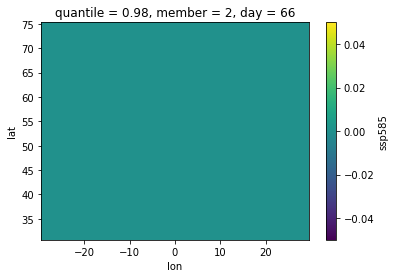

In [9]:
gust_pp_sel.isel(day=3,member=2).plot()

/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':'Event ID 12: (0, 92)'}>

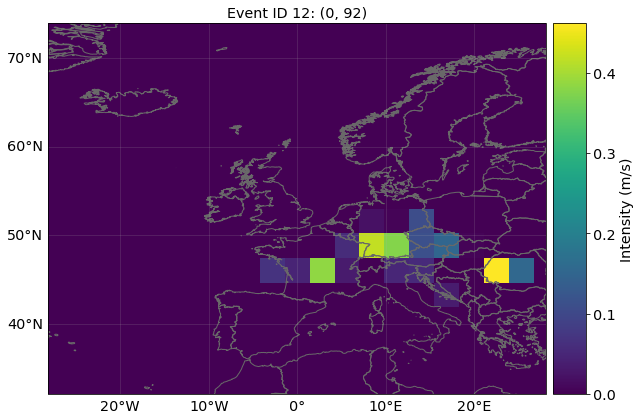

In [61]:
haz.plot_intensity(event=12,smooth=False)

In [121]:
cutarea = 2E6
q=0.98
U = ncdfw.stack(real=("member",timeres))
dim="real"
print('Dims in: '+str(U.dims))
Upast = U[pastname]
Upast_qt = Upast.quantile(q,dim=dim)    
U_mask = U.where(U>Upast_qt)
print('Dims in masked: '+str(U_mask.dims))

latres, lonres = get_lat_lon_res(U)
gcarea = latres*lonres*100*100 #gridcell area approximated: 1 deg corresponds to 100km
threshold = round(cutarea/gcarea)
print(threshold)
U_mask_s = U_mask.dropna(dim=dim,thresh=threshold)
print('Dims out masked: '+str(U_mask_s.dims))
U_mask_us = U_mask_s.unstack().fillna(0)
print('Dims out masked unstack: '+str(U_mask_us.dims))

Dims in: Frozen({'lat': 16, 'lon': 21, 'real': 16377})
Dims in masked: Frozen({'lat': 16, 'lon': 21, 'real': 16377})
25
Dims out masked: Frozen({'lat': 16, 'lon': 21, 'real': 1872})
Dims out masked unstack: Frozen({'lat': 16, 'lon': 21, 'member': 3, 'day': 1596})


In [122]:
stack=True
cutarea = 2E6
q=0.98
#U = ncdfw.stack(real=("member",timeres))
U = ncdfw
dim = "day"
Upast = U[pastname]
Ufut = U[futname]
if stack:
    Upast = Upast.stack(real=("member",timeres))
    Ufut = Ufut.stack(real=("member",timeres))
    dim="real"  
else:
    dim = timeres
    
Upast_qt = Upast.quantile(q,dim=dim)    
U_mask_past = Upast.where(Upast>Upast_qt)
U_mask_fut = Ufut.where(Ufut>Upast_qt)
latres, lonres = get_lat_lon_res(U)
gcarea = latres*lonres*100*100 #gridcell area approximated: 1 deg corresponds to 100km
threshold = round(cutarea/gcarea)

U_mask_past = U_mask_past.dropna(dim=dim,thresh=threshold) #keep fields for which at least X values are not NaN
U_mask_fut = U_mask_fut.dropna(dim=dim,thresh=threshold) #keep fields for which at least X values are not NaN

#unstack and assemble
U_mask_past = U_mask_past.unstack().fillna(0)
U_mask_fut = U_mask_fut.unstack().fillna(0)

In [123]:
U_mask = xr.combine_by_coords([U_mask_past, U_mask_fut]).fillna(0)

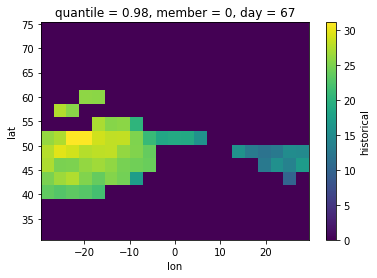

In [139]:
U_mask_us[pastname].isel(member=0,day=4).plot()